In [1]:
from datetime import date
import numpy as np
import os
import pandas as pd
import time

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from sklearn.cluster import KMeans
from io import StringIO

# Settings

In [2]:
dataDir = "./P1_Foodmart"
transaction_filename = "FoodMart-Transactions-1998.csv"
product_filename = "Product-Lookup.csv"
customer_filename = "Customer-Lookup.csv"

# Input

In [3]:
# input: transactions
df_trans = pd.read_csv(os.path.join(dataDir,transaction_filename))

In [4]:
# 將 transaction_date 拆成 datetime 格式
df_trans['transaction_date'] = pd.to_datetime(df_trans['transaction_date'], format="%m/%d/%Y")

# 篩選 1998 年 1 月到 10 月的交易
df_trans = df_trans[df_trans['transaction_date'].dt.month <= 10]

In [5]:
df_trans.head()

,transaction_date,stock_date,product_id,customer_id,store_id,quantity
0,1998-01-01,12/25/1997,4,2439,10,3
1,1998-01-01,12/28/1997,11,4284,10,3
2,1998-01-01,12/28/1997,12,534,10,3
3,1998-01-01,12/29/1997,14,9743,10,2
4,1998-01-01,12/27/1997,16,3608,10,3


In [6]:
# input: products
df_prod = pd.read_csv(os.path.join(dataDir,product_filename))

In [7]:
df_prod.head()

,product_id,product_brand,product_name,product_sku,product_retail_price,product_cost,product_weight,recyclable,low_fat
0,1,Washington,Washington Berry Juice,90748583674,2.85,0.94,8.39,NaN,NaN
1,2,Washington,Washington Mango Drink,96516502499,0.74,0.26,7.42,NaN,1.0
2,3,Washington,Washington Strawberry Drink,58427771925,0.83,0.40,13.10,1.0,1.0
3,4,Washington,Washington Cream Soda,64412155747,3.64,1.64,10.60,1.0,NaN
4,5,Washington,Washington Diet Soda,85561191439,2.19,0.77,6.66,1.0,NaN


# Data Preprocessing

## RFM: monetary

In [8]:
# look up the price of the product by its product_id
def lookup_price(product_id, df=df_prod):
    return df_prod[df_prod["product_id"]==product_id]["product_retail_price"].values[0]

In [9]:
df_trans["price"] = [lookup_price(pid) for pid in df_trans["product_id"]]

In [10]:
df_trans.head()

,transaction_date,stock_date,product_id,customer_id,store_id,quantity,price
0,1998-01-01,12/25/1997,4,2439,10,3,3.64
1,1998-01-01,12/28/1997,11,4284,10,3,3.51
2,1998-01-01,12/28/1997,12,534,10,3,1.54
3,1998-01-01,12/29/1997,14,9743,10,2,1.93
4,1998-01-01,12/27/1997,16,3608,10,3,3.83


In [11]:
df_trans["amount"] = df_trans["quantity"]*df_trans["price"]

In [12]:
df_trans.head()

,transaction_date,stock_date,product_id,customer_id,store_id,quantity,price,amount
0,1998-01-01,12/25/1997,4,2439,10,3,3.64,10.92
1,1998-01-01,12/28/1997,11,4284,10,3,3.51,10.53
2,1998-01-01,12/28/1997,12,534,10,3,1.54,4.62
3,1998-01-01,12/29/1997,14,9743,10,2,1.93,3.86
4,1998-01-01,12/27/1997,16,3608,10,3,3.83,11.49


In [13]:
m_value_tmp = df_trans.groupby(["customer_id","transaction_date"])['amount'].apply(sum)
m_value_tmp

C:\Users\Henry\AppData\Local\Temp\ipykernel_496\3333363460.py:1: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  m_value_tmp = df_trans.groupby(["customer_id","transaction_date"])['amount'].apply(sum)


customer_id  transaction_date
3            1998-03-29          67.15
             1998-04-17          37.48
6            1998-01-16           6.52
             1998-06-25          40.46
8            1998-03-02          21.63
                                 ...  
10280        1998-08-23          41.13
10281        1998-01-07          49.49
             1998-06-23          66.36
             1998-07-17          88.85
             1998-08-01          42.20
Name: amount, Length: 30362, dtype: float64

C:\Users\Henry\AppData\Local\Temp\ipykernel_496\1300281508.py:1: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  m_value = df_trans.groupby(["customer_id"])['amount'].apply(sum)


<Axes: >

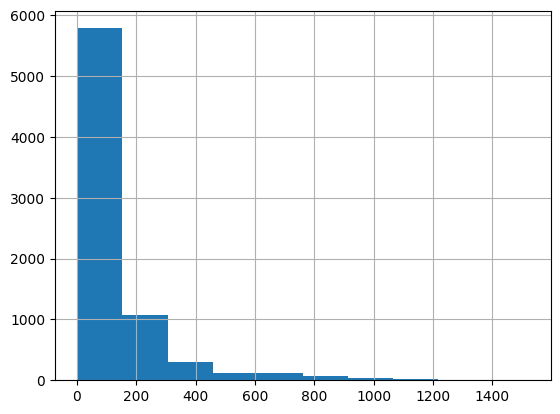

In [14]:
m_value = df_trans.groupby(["customer_id"])['amount'].apply(sum)
m_value.hist()

## RFM: recency

In [15]:
#df_trans["trans_days"] = [(date(int(d.split("/")[2]),int(d.split("/")[0]),int(d.split("/")[1]))-date(1998,12,31)).days for d in df_trans["transaction_date"]]
#df_trans["trans_days"] = (date(1998, 12, 31) - df_trans["transaction_date"].dt.date).dt.days
from datetime import datetime

# 設定基準日為 1998/12/31
ref_date = datetime(1998, 12, 31)

# 計算距離基準日的天數（會是負數，越接近 12/31 值越大）
df_trans["trans_days"] = (df_trans["transaction_date"] - ref_date).dt.days

# 取每位顧客最大 trans_days（即最後一次交易距今多久）
r_value = df_trans.groupby("customer_id")["trans_days"].max()

df_trans.head()

,transaction_date,stock_date,product_id,customer_id,store_id,quantity,price,amount,trans_days
0,1998-01-01,12/25/1997,4,2439,10,3,3.64,10.92,-364
1,1998-01-01,12/28/1997,11,4284,10,3,3.51,10.53,-364
2,1998-01-01,12/28/1997,12,534,10,3,1.54,4.62,-364
3,1998-01-01,12/29/1997,14,9743,10,2,1.93,3.86,-364
4,1998-01-01,12/27/1997,16,3608,10,3,3.83,11.49,-364


In [16]:
r_trans_tmp = df_trans.groupby("customer_id")['trans_days'].unique()
r_trans_tmp

customer_id
3                                          [-277, -258]
6                                          [-349, -189]
8        [-304, -260, -211, -188, -167, -112, -97, -90]
9                                           [-248, -83]
10                             [-348, -308, -263, -201]
                              ...                      
10275                          [-309, -238, -228, -179]
10277                                 [-280, -100, -74]
10278                          [-307, -288, -282, -247]
10280                    [-315, -263, -207, -206, -130]
10281                          [-358, -191, -167, -152]
Name: trans_days, Length: 7532, dtype: object

<Axes: >

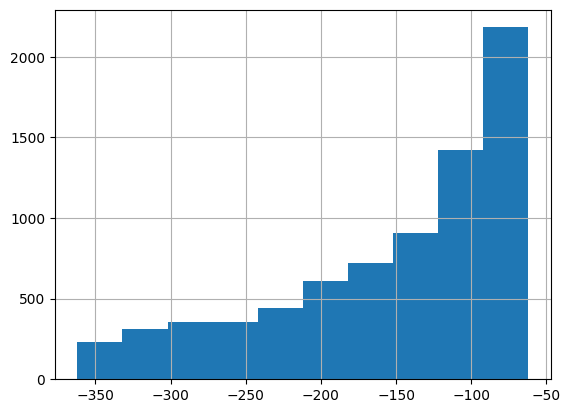

In [17]:
r_value = df_trans.groupby("customer_id")['trans_days'].max()
r_value.hist()

## RFM: frequency

<Axes: >

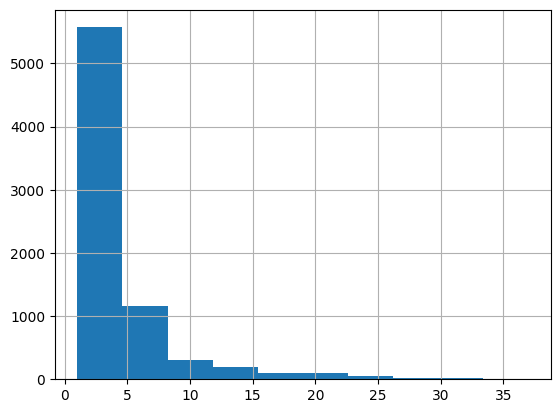

In [18]:
f_value = df_trans.groupby(["customer_id"])["transaction_date"].nunique()
f_value.hist()

In [19]:
r_min = r_value.min()
r_max = r_value.max()
f_min = f_value.min()
f_max = f_value.max()
m_min = m_value.min()
m_max = m_value.max()

rfm_summary = pd.DataFrame({
    'Metric': ['Recency (R)', 'Frequency (F)', 'Monetary (M)'],
    'Min': [r_min, f_min, m_min],
    'Max': [r_max, f_max, m_max]
})

# 顯示表格
print(rfm_summary)

          Metric     Min      Max
0    Recency (R) -362.00   -62.00
1  Frequency (F)    1.00    37.00
2   Monetary (M)    1.42  1521.42


# Observation: RFM 

In [20]:
df_user = pd.concat([f_value, m_value, r_value], axis=1)
df_user.columns = ["f","m","r"]

In [21]:
df_user.head()

,f,m,r
customer_id,,,
3,2,104.63,-258
6,2,46.98,-189
8,8,204.44,-90
9,2,89.58,-83
10,4,109.17,-201


### 第二題

<Axes: xlabel='r', ylabel='f'>

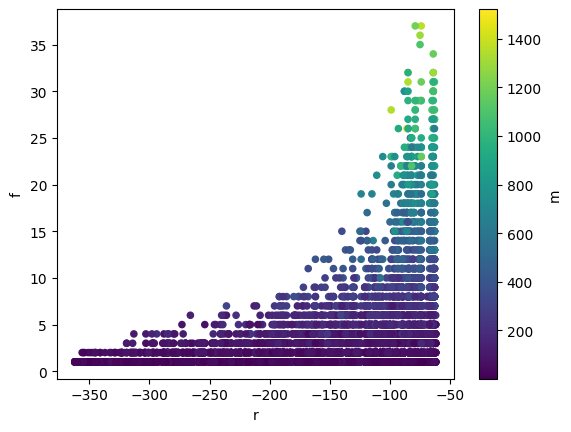

In [22]:
df_user.plot.scatter(y="f", x="r", c="m", colormap='viridis')

c:\Users\Henry\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\plotting\_matplotlib\core.py:1345: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<Axes: xlabel='r', ylabel='f'>

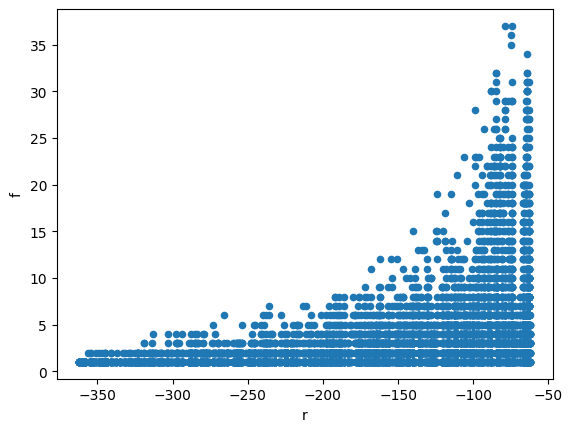

In [23]:
# RF 二維散布圖
df_user.plot.scatter(x="r", y="f", colormap='viridis')

c:\Users\Henry\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\plotting\_matplotlib\core.py:1345: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<Axes: xlabel='r', ylabel='m'>

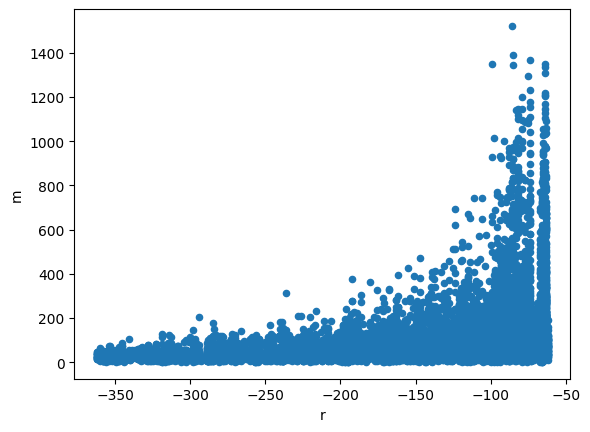

In [24]:
# RM 二維散布圖
df_user.plot.scatter(x="r", y="m", colormap='viridis')

c:\Users\Henry\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\plotting\_matplotlib\core.py:1345: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<Axes: xlabel='f', ylabel='m'>

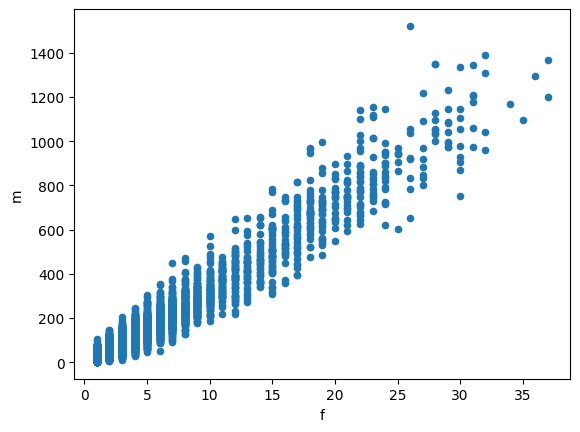

In [25]:
# FM 二維散布圖
df_user.plot.scatter(x="f", y="m", colormap='viridis')

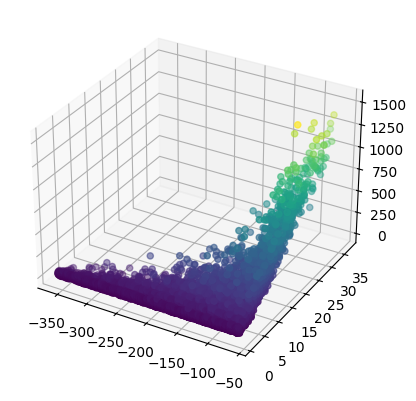

In [26]:
ax = plt.axes(projection='3d')
ax.scatter3D(df_user["r"], df_user["f"], df_user["m"], c=df_user["m"], cmap='viridis');

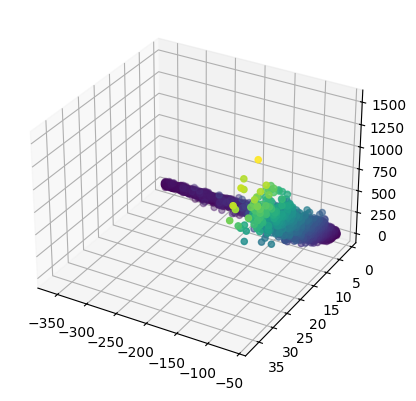

In [27]:
ax = plt.axes(projection='3d')
ax.scatter3D(df_user["r"], df_user["f"], df_user["m"], c=df_user["m"], cmap='viridis');
ax.invert_yaxis()

ax.view_init(elev, azim)：設定 3D 圖表的仰角 (elevation) 和方位角 (azimuth)，從而改變視角。

elev：仰角(elevation)，表示從 XY 平面向上或向下看的角度。

azim：方位角(azimuth)，表示在 XY 平面中旋轉的角度。

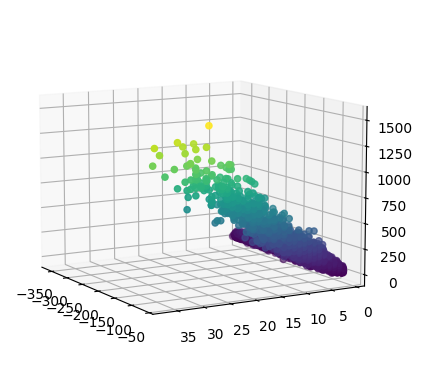

In [28]:
ax = plt.axes(projection='3d')
ax.scatter3D(df_user["r"], df_user["f"], df_user["m"], c=df_user["m"], cmap='viridis');
ax.invert_yaxis()
ax.view_init(elev=10,azim=-30)

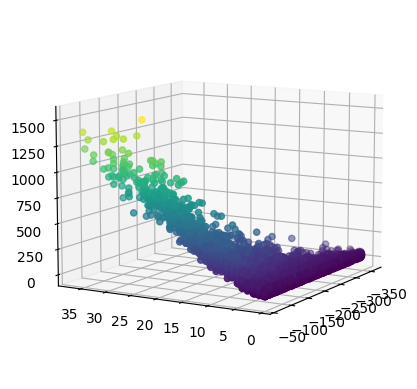

In [29]:
ax = plt.axes(projection='3d')
ax.scatter3D(df_user["r"], df_user["f"], df_user["m"], c=df_user["m"], cmap='viridis');
ax.invert_yaxis()
ax.view_init(elev=10,azim=30)

### 第三題

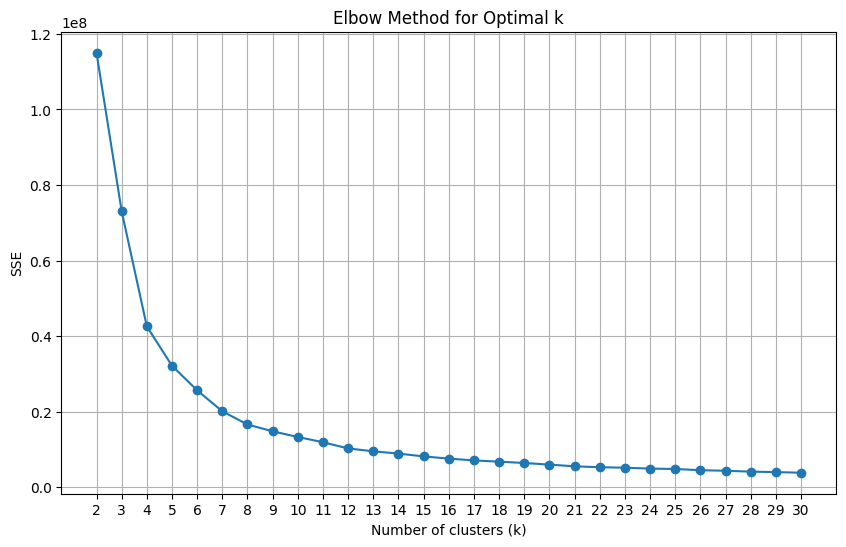

In [30]:
rfm_data = df_user[["f", "m", "r"]]

sse = []

for k in range(2, 31):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(rfm_data)
    sse.append(kmeans.inertia_)
    
plt.figure(figsize=(10, 6))
plt.plot(range(2, 31), sse, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('SSE')
plt.xticks(range(2, 31))
plt.grid()
plt.show()

### 第四題

In [31]:
kmeans_best = KMeans(n_clusters=4, random_state=42)
kmeans_best.fit(rfm_data)

# 抓出中心點並排序
centroids = pd.DataFrame(kmeans_best.cluster_centers_, columns=['F', 'M', 'R'])
centroids_sorted = centroids.sort_values(by='M', ascending=False)
print(centroids_sorted)

           F           M           R
2  21.387755  802.550510  -75.853741
1   8.887454  295.708958  -94.205720
3   2.803859   79.768588 -116.478605
0   1.470393   40.908039 -263.306490


### 第五題

In [32]:
# Fit the KMeans model
kmeans_best = KMeans(n_clusters=4, random_state=42)
kmeans_best.fit(rfm_data)

# Add the cluster labels to df_user
df_user['Cluster'] = kmeans_best.labels_

# Now you can proceed with your analysis
group2_count = df_user[df_user['Cluster'] == 2].shape[0]
print(f"Group 2 count: {group2_count}")

print(f"--------------------")
group0_count = df_user[df_user['Cluster'] == 0].shape[0]
group1_count = df_user[df_user['Cluster'] == 1].shape[0]
group3_count = df_user[df_user['Cluster'] == 3].shape[0]
print(f"Group 0 count: {group0_count}")
print(f"Group 1 count: {group1_count}")
print(f"Group 2 count: {group2_count}")
print(f"Group 3 count: {group3_count}")

Group 2 count: 294
--------------------
Group 0 count: 2112
Group 1 count: 1083
Group 2 count: 294
Group 3 count: 4043


In [33]:
# Fit the KMeans model
kmeans_best = KMeans(n_clusters=4, random_state=42)
kmeans_best.fit(rfm_data)

# Add the cluster labels to df_user
df_user['Cluster'] = kmeans_best.labels_

group1 = df_user[df_user['Cluster'] == 2]
print("R range:", [group1['r'].min(), group1['r'].max()])
print("F range:", [group1['f'].min(), group1['f'].max()])
print("M range:", [group1['m'].min(), group1['m'].max()])

R range: [-124, -63]
F range: [10, 37]
M range: [549.7900000000001, 1521.4199999999998]


In [34]:
# 讀取資料
# input: transactions
df_trans = pd.read_csv(os.path.join(dataDir,transaction_filename))
df_prod = pd.read_csv(os.path.join(dataDir,product_filename))
df_customers = pd.read_csv(os.path.join(dataDir,customer_filename))
df_user['Cluster'] = kmeans_best.labels_

# 合併資料
df_merged = pd.merge(df_trans, df_prod, on='product_id', how='left')
df_merged = pd.merge(df_merged, df_customers, on='customer_id', how='left')
df_merged = pd.merge(df_merged, df_user, on='customer_id', how='left')

# 提取 cluster2
cluster2 = df_merged[df_merged['Cluster'] == 2]

In [35]:
# 分析交易層面
print("=== Cluster 2 產品偏好 ===")
product_counts = cluster2['product_name'].value_counts()
print(product_counts)

=== Cluster 2 產品偏好 ===
product_name
Carlson Chocolate Milk         44
High Top New Potatos           44
Super Chunky Peanut Butter     43
Shady Lake Ravioli             43
Carrington Turkey TV Dinner    43
                               ..
Plato Sesame Oil               14
Colony White Bread             14
Pleasant Canned Tuna in Oil    13
Washington Berry Juice         11
CDR Apple Preserves             7
Name: count, Length: 1559, dtype: int64
